# Getting Started

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('/teamspace/studios/this_studio/MAI_DUL_WS24')
# os.chdir('../../')
os.getcwd()

'/teamspace/studios/this_studio/MAI_DUL_WS24'

In [2]:
# install latest version deepul package
!pip install -e .

Obtaining file:///teamspace/studios/this_studio/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///teamspace/studios/this_studio/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
from deepul.hw2_helper import *

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the SVHN and CIFAR10. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from homeworks.hw2.vae import VQVAE, TransformerPrior

In [5]:
def evaluate_vqvae(model, loader, device, beta):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, _ in loader:
            x = x * 2 - 1
            x = x.to(device)
            x_recon, commitment_loss, codebook_loss, _ = model(x)
            loss = F.mse_loss(x_recon, x) + beta * commitment_loss + codebook_loss
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [6]:
def train_vqvae(model, train_loader, test_loader, device, beta, num_epochs=50, learning_rate=1e-3, ):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = [evaluate_vqvae(model, test_loader, device, beta)]  # Initial test loss
    
    for epoch in range(num_epochs):
        model.train()
        pbar = tqdm(train_loader, unit='batch')

        for batch_idx, (x, _) in enumerate(pbar):
            x = x * 2 - 1  # Scale to [-1, 1]
            x = x.to(device)
            
            optimizer.zero_grad()
            x_recon, commitment_loss, codebook_loss, _ = model(x)
            
            recon_loss = F.mse_loss(x_recon, x)
            loss = recon_loss + beta * commitment_loss + codebook_loss
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            pbar.set_description(desc=f"batch_loss={loss.item():.4f}")
        
        # Evaluate on test set
        test_loss = evaluate_vqvae(model, test_loader, device, beta)
        test_losses.append(test_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}')
        
    return np.array(train_losses), np.array(test_losses)

In [7]:
def prepare_data(data, device):
    B = data.size(0)
    data = data.view(B, -1)
    bos = torch.full((B, 1), 128, device=device, dtype=torch.long)  # 128 represents <bos>
    return torch.cat([bos, data], dim=1)

In [8]:
def evaluate_transformer(vqvae, transformer, loader, device, causal_mask):
    transformer.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            indices = vqvae.encode(x)
            indices = prepare_data(indices, device)

            input_seq = indices[:, :-1]
            target_seq = indices[:, 1:]

            seq_len = input_seq.size(1)
            current_mask = causal_mask[:seq_len, :seq_len]

            logits = transformer(input_seq, current_mask)
            
            loss = criterion(logits.reshape(-1, 128), target_seq.reshape(-1))
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [9]:
def train_transformer(vqvae, transformer, train_loader, test_loader, device, num_epochs=50, learning_rate=1e-3):
    optimizer = optim.Adam(transformer.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    seq_len = 8 * 8 + 1
    causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    
    train_losses = []
    test_losses = [evaluate_transformer(vqvae, transformer, test_loader, device, causal_mask)]
    
    for epoch in range(num_epochs):
        transformer.train()
        pbar = tqdm(train_loader, unit='batch')
        
        for batch_idx, (x, _) in enumerate(pbar):
            x = x.to(device)
            
            # Get VQ-VAE encodings
            with torch.no_grad():
                indices = vqvae.encode(x)

            indices = prepare_data(indices, device)

            input_seq = indices[:, :-1]
            target_seq = indices[:, 1:]

            # Make sure we use the correct size of causal mask
            seq_len = input_seq.size(1)
            current_mask = causal_mask[:seq_len, :seq_len]

            # Train transformer
            optimizer.zero_grad()
            logits = transformer(input_seq, current_mask)
            
            loss = criterion(logits.reshape(-1, 128), target_seq.reshape(-1))
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            pbar.set_description(desc=f"batch_loss={loss.item():.4f}")

        # Evaluate
        test_loss = evaluate_transformer(vqvae, transformer, test_loader, device, causal_mask)
        test_losses.append(test_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}')
    
    return np.array(train_losses), np.array(test_losses)

In [10]:
@torch.no_grad()
def sample_images(vqvae, transformer, device, n_samples=100):
    vqvae.eval()
    transformer.eval()

    # Start with start token
    curr_sequence = torch.full((n_samples, 1), 128, device=device)
    
    # Generate sequence
    for _ in range(64):  # 8x8 latents
        logits = transformer(curr_sequence)
        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, 1)
        curr_sequence = torch.cat([curr_sequence, next_token], dim=1)

    # Remove start token and reshape
    indices = curr_sequence[:, 1:].view(n_samples, 8, 8)
    
    # Decode
    samples = vqvae.decode(indices)
    samples = (samples + 1) / 2  # Scale to [0, 1]
    samples = samples.clamp(0, 1)
    samples = (samples * 255).cpu().numpy().transpose(0, 2, 3, 1).astype(np.uint8)
    
    return samples

In [11]:
@torch.no_grad()
def get_reconstructions(vqvae, test_loader, device, n_samples=50):
    vqvae.eval()
    
    originals = []
    reconstructions = []
    
    for x, _ in test_loader:
        if len(originals) >= n_samples:
            break
            
        samples_needed = n_samples - len(originals)
        x = x[:samples_needed].to(device)
        
        x_recon = vqvae(x * 2 - 1)[0]
        x_recon = (x_recon + 1) / 2
        x_recon = x_recon.clamp(0, 1)
        
        orig_batch = (x * 255).cpu().numpy().transpose(0, 2, 3, 1).astype(np.uint8)
        recon_batch = (x_recon * 255).cpu().numpy().transpose(0, 2, 3, 1).astype(np.uint8)
        
        originals.extend(list(orig_batch))
        reconstructions.extend(list(recon_batch))
    
    orig_array = np.stack(originals)
    recon_array = np.stack(reconstructions)
    
    pairs = np.empty((n_samples * 2,) + orig_array.shape[1:], dtype=np.uint8)
    pairs[0::2] = orig_array
    pairs[1::2] = recon_array
    
    return pairs

In [12]:
def q3(train_data, test_data, dset_id):
    """
    train_data: torch dataset with (n_train, 3, 32, 32) color images as tensors with 256 values rescaled to [0, 1]
    test_data: torch dataset with (n_test, 3, 32, 32) color images as tensors with 256 values rescaled to [0, 1]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """
    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")

    print(f"Using device: {device}")

    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': False} if torch.cuda.is_available() else \
             {'num_workers': 0} if torch.backends.mps.is_available() else \
             {}

    # Hyperparameters
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 20
    beta = 0.25
    
    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)
    
    # Initialize models
    vqvae = VQVAE().to(device)
    transformer = TransformerPrior().to(device)
    
    # Train VQ-VAE
    print("Train and Evaluate VQ-VAE")
    vqvae_train_losses, vqvae_test_losses = train_vqvae(
        vqvae, train_loader, test_loader, device, beta, num_epochs, learning_rate
    )
    
    # Train Transformer
    print("Train and Evaluate Transformer Prior")
    transformer_train_losses, transformer_test_losses = train_transformer(
        vqvae, transformer, train_loader, test_loader, device, num_epochs, learning_rate
    )
    
    # Generate samples
    samples = sample_images(vqvae, transformer, device, n_samples=100)
    
    # Get reconstructions
    reconstructions = get_reconstructions(vqvae, test_loader, device, n_samples=50)
    
    return (
        vqvae_train_losses,
        vqvae_test_losses,
        transformer_train_losses,
        transformer_test_losses,
        samples,
        reconstructions
    )

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

Using downloaded and verified file: homeworks/hw2/data/train_32x32.mat
Using downloaded and verified file: homeworks/hw2/data/test_32x32.mat
Using device: cuda
Train and Evaluate VQ-VAE


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 1/20, Test Loss: 0.3852


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 2/20, Test Loss: 0.1469


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 3/20, Test Loss: 0.0826


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 4/20, Test Loss: 0.0621


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 5/20, Test Loss: 0.0622


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 6/20, Test Loss: 0.0616


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 7/20, Test Loss: 0.0430


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 8/20, Test Loss: 0.0426


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 9/20, Test Loss: 0.0442


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 10/20, Test Loss: 0.0464


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 11/20, Test Loss: 0.0401


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 12/20, Test Loss: 0.0388


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 13/20, Test Loss: 0.0378


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 14/20, Test Loss: 0.0389


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 15/20, Test Loss: 0.0331


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 16/20, Test Loss: 0.0626


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 17/20, Test Loss: 0.0339


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 18/20, Test Loss: 0.0414


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 19/20, Test Loss: 0.0369


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 20/20, Test Loss: 0.0374
Train and Evaluate Transformer Prior


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 1/20, Test Loss: 1.5663


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 2/20, Test Loss: 1.5245


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 3/20, Test Loss: 1.4984


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 4/20, Test Loss: 1.4801


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 5/20, Test Loss: 1.4681


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 6/20, Test Loss: 1.4557


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 7/20, Test Loss: 1.4498


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 8/20, Test Loss: 1.4404


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 9/20, Test Loss: 1.4373


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 10/20, Test Loss: 1.4408


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 11/20, Test Loss: 1.4340


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 12/20, Test Loss: 1.4278


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 13/20, Test Loss: 1.4295


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 14/20, Test Loss: 1.4323


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 15/20, Test Loss: 1.4266


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 16/20, Test Loss: 1.4297


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 17/20, Test Loss: 1.4269


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 18/20, Test Loss: 1.4286


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 19/20, Test Loss: 1.4331


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 20/20, Test Loss: 1.4316
VQ-VAE Final Test Loss: 0.0374
Transformer Prior Final Test Loss: 1.4316


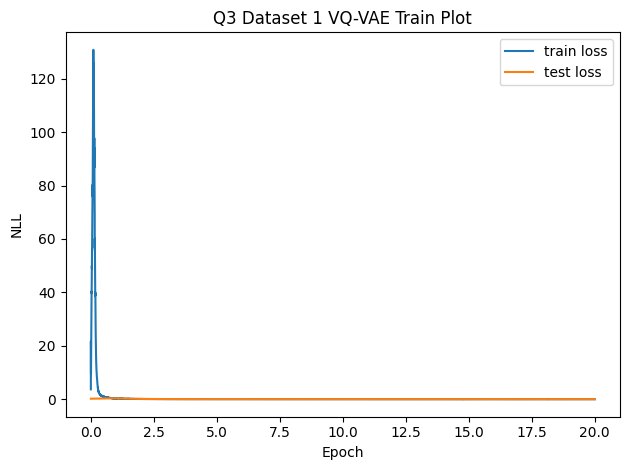

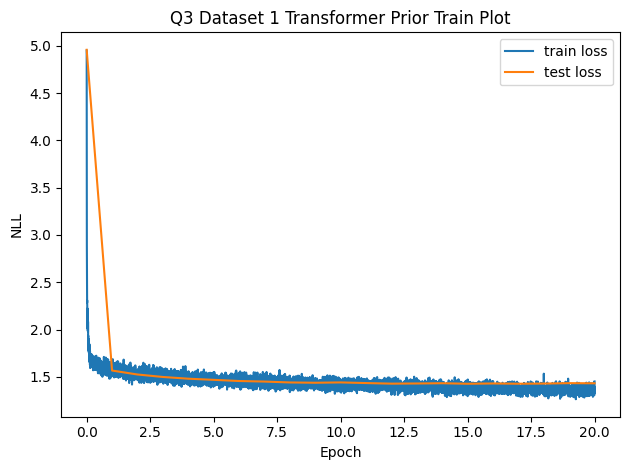

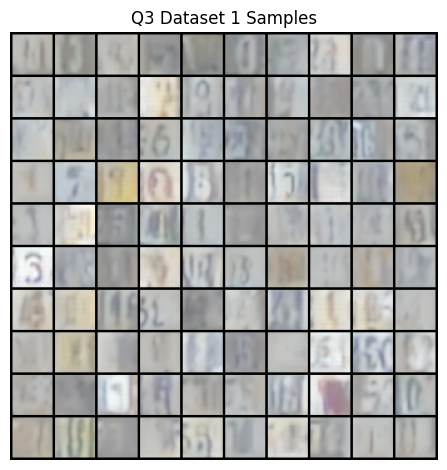

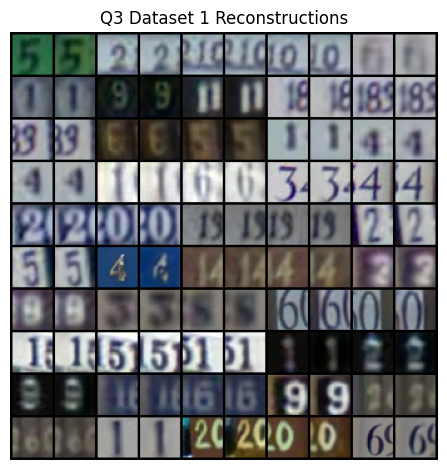

In [13]:
q3_save_results(1, q3)

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
Train and Evaluate VQ-VAE


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 1/20, Test Loss: 1.1364


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 2/20, Test Loss: 0.3667


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 3/20, Test Loss: 0.2293


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 4/20, Test Loss: 0.1901


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 5/20, Test Loss: 0.1681


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 6/20, Test Loss: 0.1629


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 7/20, Test Loss: 0.1563


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 8/20, Test Loss: 0.1627


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 9/20, Test Loss: 0.1612


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 10/20, Test Loss: 0.1592


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 11/20, Test Loss: 0.1581


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 12/20, Test Loss: 0.1519


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 13/20, Test Loss: 0.1484


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 14/20, Test Loss: 0.1478


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 15/20, Test Loss: 0.1427


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 16/20, Test Loss: 0.1393


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 17/20, Test Loss: 0.1424


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 18/20, Test Loss: 0.1376


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 19/20, Test Loss: 0.1368


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 20/20, Test Loss: 0.1354
Train and Evaluate Transformer Prior


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 1/20, Test Loss: 1.7465


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 2/20, Test Loss: 1.7324


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 3/20, Test Loss: 1.7263


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 4/20, Test Loss: 1.7171


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 5/20, Test Loss: 1.7121


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 6/20, Test Loss: 1.7083


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 7/20, Test Loss: 1.7059


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 8/20, Test Loss: 1.7002


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 9/20, Test Loss: 1.6988


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 10/20, Test Loss: 1.6958


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 11/20, Test Loss: 1.6957


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 12/20, Test Loss: 1.6937


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 13/20, Test Loss: 1.6945


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 14/20, Test Loss: 1.6927


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 15/20, Test Loss: 1.6926


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 16/20, Test Loss: 1.6936


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 17/20, Test Loss: 1.6920


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 18/20, Test Loss: 1.6928


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 19/20, Test Loss: 1.6955


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 20/20, Test Loss: 1.6979
VQ-VAE Final Test Loss: 0.1354
Transformer Prior Final Test Loss: 1.6979


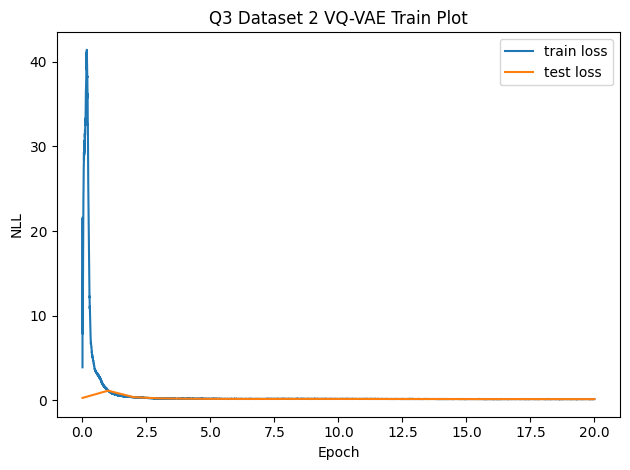

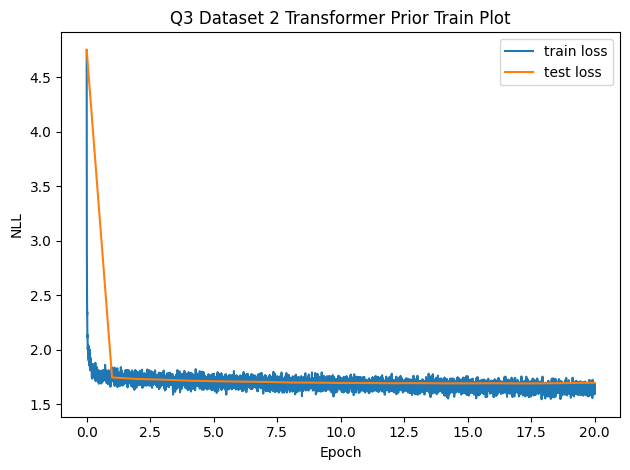

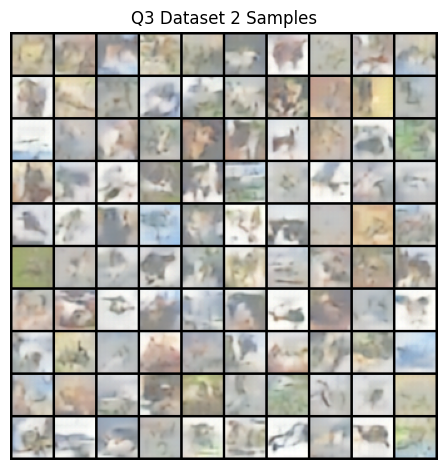

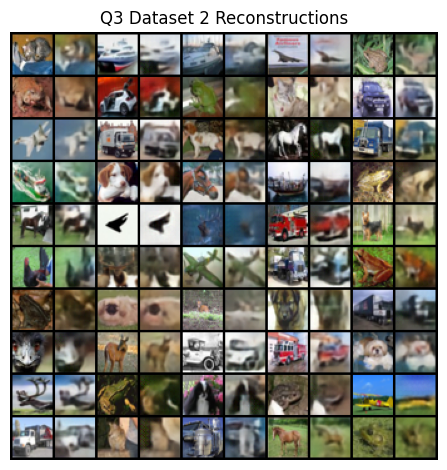

In [14]:
q3_save_results(2, q3)